In [37]:
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation
from scipy import stats
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 7, 
                                   'axes.titlesize': 9,
                                   'axes.labelsize': 8,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 7,
                                   'ytick.labelsize': 7,
                                   'legend.title_fontsize' : 8,
                                   'legend.fontsize' : 7,
                                   'legend.markerscale': 0.7,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Theory

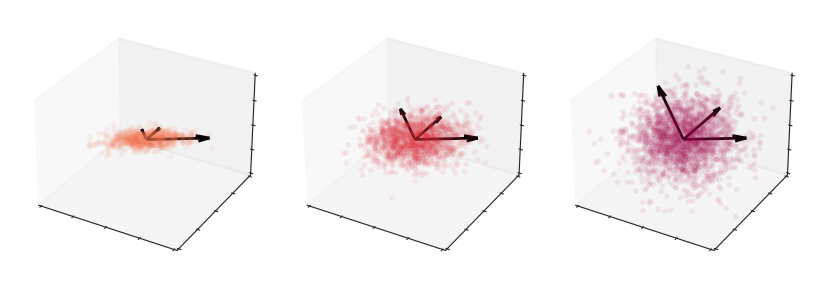

In [7]:
np.random.seed(0)

n_samples_base = 500

eigvecs = Rotation.from_euler('xyz', [0*np.pi/4, .5*np.pi/4, 0*np.pi/4]).apply(np.eye(3))
all_eigvals = np.array([[1, .125, .037],
                        [1, .5, .33], 
                        [1, 1, 1]])

fig = plt.figure(figsize=(4,  4 / len(all_eigvals)))

for i, eigvals in enumerate(all_eigvals):
    ax = fig.add_subplot(1, len(all_eigvals), i + 1, projection='3d')
    ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
    ax.grid(False)
    
    n_samples = int((4/3 * np.pi * (eigvals ** .2).prod()) * n_samples_base)
    samples = np.random.multivariate_normal(mean=[0, 0, 0], 
                                            cov=eigvecs @ np.diag(eigvals / 8) @ eigvecs.T, 
                                            size=n_samples)
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=2, alpha=0.05, 
               c=sns.color_palette('rocket_r').as_hex()[i + 1])
    
    radii = eigvecs * np.sqrt(eigvals)
    ax.quiver(0, 0, 0, radii[0, 0], radii[1, 0], radii[2, 0], color='black', linewidth=1, arrow_length_ratio=0.2)
    ax.quiver(0, 0, 0, radii[0, 1], radii[1, 1], radii[2, 1], color='black', linewidth=1, arrow_length_ratio=0.2)
    ax.quiver(0, 0, 0, radii[0, 2], radii[1, 2], radii[2, 2], color='black', linewidth=1, arrow_length_ratio=0.2)
    
    ax.tick_params(axis='both', labelbottom=False, labelleft=False, which='both')

plt.savefig('saved/depictions_ED-samples.png', dpi=300, transparent=True)
plt.show()

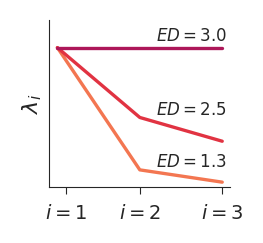

In [13]:
fig, ax = plt.subplots(figsize=(1.2, 1.1))

ax.plot([1, 2, 3], all_eigvals[0, :], color=sns.color_palette('rocket_r')[1])
ax.plot([1, 2, 3], all_eigvals[1, :], label=r'$ED = 2.5$', color=sns.color_palette('rocket_r')[2])
ax.plot([1, 2, 3], all_eigvals[2, :], label=r'$ED = 3$', color=sns.color_palette('rocket_r')[3])
ax.text(2.2, .15, r'$ED = 1.3$', fontsize=6)
ax.text(2.2, .52, r'$ED = 2.5$', fontsize=6)
ax.text(2.2, 1.05, r'$ED = 3.0$', fontsize=6)
ax.set(ylim=(0, 1.2), ylabel=r'$\lambda_i$')
ax.set_xticks([1.1, 2, 3])
ax.set_xticklabels([r'$i=1$', r'$i=2$', r'$i=3$'], minor=False)
ax.tick_params(axis='x', labelbottom=True, which='major')
ax.tick_params(axis='y', labelleft=False, left=False)

plt.savefig('saved/depictions_ED-eigenspectra.png', dpi=300, transparent=True)
plt.show()

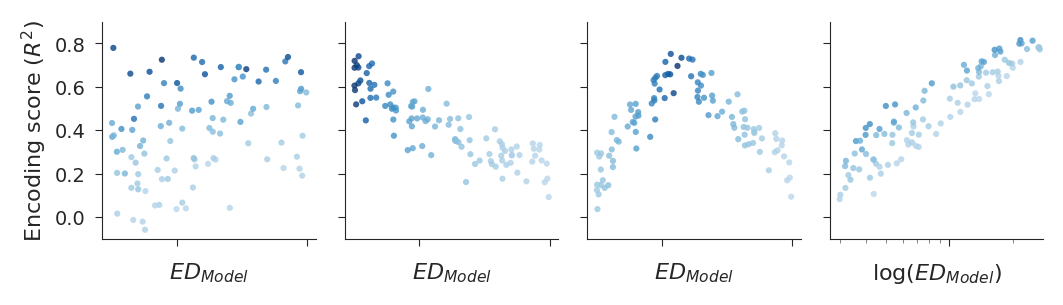

In [18]:
data_constant = pd.read_csv('data/constant_ap_simulations.csv')
data_uncorr = pd.read_csv('data/uncorrelated_ap_ed_simulations.csv')
data_negcorr = pd.read_csv('data/negcorrelated_ap_ed_simulations.csv')
data_invu = pd.read_csv('data/invertedu_ap_simulations.csv')

fig, axs = plt.subplots(1, 4, figsize=(5.2, 1.4))
cmap = sns.color_palette('Blues', as_cmap=True)

sns.scatterplot(data=data_uncorr, x='model_ed', y='r2_ceiled', hue='model_alignment_strength',
                linewidth=0, s=5, palette=cmap, hue_norm=(-0.4, 1), alpha=0.8, ax=axs[0])
axs[0].legend().remove()

sns.scatterplot(data=data_negcorr, x='model_ed', y='r2_ceiled', hue='model_alignment_strength',
                linewidth=0, s=5, palette=cmap, hue_norm=(-0.4, 1), alpha=0.8, ax=axs[1])
axs[1].legend().remove()

sns.scatterplot(data=data_invu, x='model_ed', y='r2_ceiled', hue='model_alignment_strength',
                linewidth=0, s=5, palette=cmap, hue_norm=(-0.4, 1), alpha=0.8, ax=axs[2])
axs[2].legend().remove()

sns.scatterplot(data=data_constant, x='model_ed', y='r2_ceiled', hue='model_alignment_strength',
                linewidth=0, s=5, palette=cmap, hue_norm=(-0.4, 1), alpha=0.8, ax=axs[3])
axs[3].legend().remove()

ylim = (-.1, 0.9)
axs[0].set(xlabel=r'$ED_{Model}$', ylabel=r'Encoding score ($R^2$)', ylim=ylim)
axs[1].set(xlabel=r'$ED_{Model}$', ylabel=None, ylim=ylim)
axs[2].set(xlabel=r'$ED_{Model}$', ylabel=None, ylim=ylim)
axs[3].set(xlabel=r'$\log (ED_{Model})$', ylabel=None, xscale='log', xlim=(None, 28), ylim=ylim)
for i in range(4):
    axs[i].axes.xaxis.set_ticklabels([])
    if i > 0:
        axs[i].axes.yaxis.set_ticklabels([])

plt.savefig('saved/simulations_results-outcomes.png', dpi=300, transparent=True)
plt.show()

---
# Results - Dimensionality of encoding models

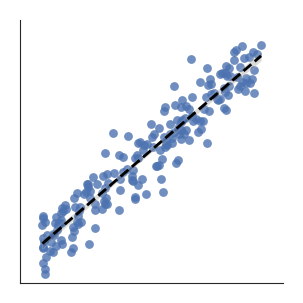

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))

x = np.random.rand(200)
y = x + np.random.normal(size=200, scale=.1)
data = pd.DataFrame({'x': x, 'y': y})
sns.regplot(data=data, x='x', y='y', 
            scatter_kws={'alpha': 0.8, 's': 10, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlim=(-0.1, 1.1), ylim=(-0.2, 1.2), xlabel=None, ylabel=None)
ax.tick_params(axis='both', bottom=False, left=False, 
               labelbottom=False, labelleft=False, which='both')

plt.savefig('saved/depictions_methodology-trend.png', dpi=300, transparent=True)
plt.show()

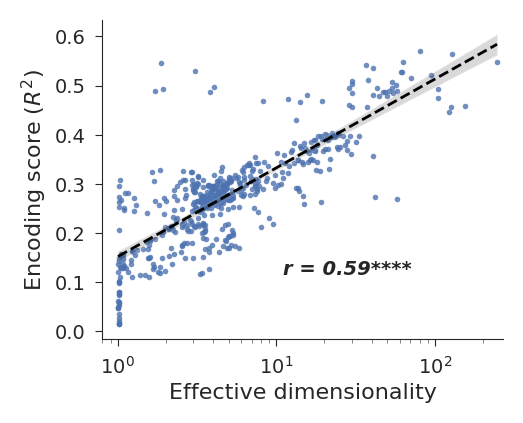

In [41]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300, transparent=True)
plt.show()

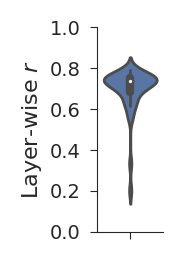

In [42]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(0.8, 1.2))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/results_ED-vs-encoding-layerwise.png', dpi=300, transparent=True)
plt.show()

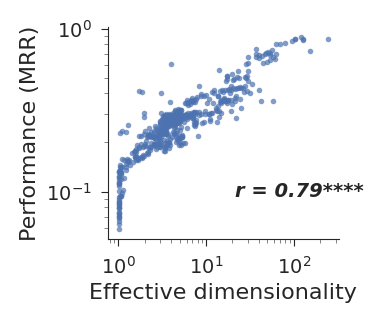

In [54]:
data = pd.read_csv(f'../../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:True.csv')
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

dataset = 'imagenet'
data = pd.merge(data, 
                pd.read_csv(f'../../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(figsize=(1.8, 1.5))

sns.scatterplot(data=data, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Effective dimensionality', ylabel='Performance (MRR)')
annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_classification-plot.png', dpi=300, transparent=True)
plt.show()